# Notebook to plot Y chromosome diversity over time

In [1]:
import numpy as np
import os  # For Saving to Folder
import pandas as pd
import matplotlib.pyplot as plt
import socket
import os as os
import sys as sys
import multiprocessing as mp
import itertools as it
from time import time
from scipy.spatial.distance import pdist

# For Arial Font
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'   # Set the defaul
rcParams['font.sans-serif'] = ['Arial']
from matplotlib import gridspec
#plt.style.use('ggplot') #..../whitegrid.mplstyle  # Nice Plotting Style

socket_name = socket.gethostname()
print(socket_name)

if socket_name.startswith("compute-"):
    print("HSM Computational partition detected.")
    path = "/n/groups/reich/hringbauer/git/punic_aDNA/"  # The Path on Midway Cluster
else:
    raise RuntimeWarning("Not compatible machine. Check!!")

os.chdir(path)  # Set the right Path (in line with Atom default)
# Show the current working directory. Should be HAPSBURG/Notebooks/ParallelRuns
print(os.getcwd())
print(f"CPU Count: {mp.cpu_count()}")
print(sys.version)

from python.plot_pca import *  # Import functions needed for the PCA plotting
from hapsburg.PackagesSupport.sqrt_scale import SquareRootScale

compute-a-16-44.o2.rc.hms.harvard.edu
HSM Computational partition detected.
/n/groups/reich/hringbauer/git/punic_aDNA
CPU Count: 32
3.8.12 (default, Sep 13 2021, 17:05:27) 
[GCC 9.2.0]


### Helper Functions

In [43]:
def filter_df_age(df, age_delta = 300, output=False):
    """Takes Dataframe df as Input, and filters to samples within age_delta of median age.
    Return filtered Dataframe and medium Age"""
    age_med = np.median(df["age"])
    idx = (df["age"]< age_med + age_delta) & (df["age"] > age_med - age_delta)
    df = df[idx].copy().reset_index(drop=False)
    if output:
        print(f"{np.sum(idx)}/{len(idx)} IIDs within {age_delta} y of median age {age_med}")
    return df, age_med

def get_y_counts(df, digits=3, col="Y_haplo"):
    """Get Y Chromosome counts from Dataframe df"""
    ys = df[col].str[:digits]
    cts = ys.value_counts().values
    return cts

def simpson_di(x):
    """ Given a count vector, returns the Simpson Diversity Index
    """
    n = np.sum(x) # Sample Size
    h = np.sum(x*(x-1)) / (n*(n-1)) # Fraction of pairs are identiclal
    
    if h==0: ### Set minimimum homo-cutoff (one homo-pair):
        h = 2 / (n*(n-1))
    return 1 / h

def frac_max_haplo(x):
    """Given a count vector, return frequency of non most-common alleles"""
    f = np.max(x) / np.sum(x)
    return f

def create_ydiv_df(df, sites=[], col_loc="loc", method="simpson",
                   col_y="Y_haplo", age_delta = 300, digits=3, min_m=5):
    """Take Meta Data as input, and for each site calculate
    the Simpson Index of Y chromosomes.
    method: simpson, frac_max_haplo
    digits: How many digits of Y haplogroup to count"""
    data = []
    
    for s in sites:
        df_t = df[df[col_loc]==s]
        df_t, age = filter_df_age(df_t, age_delta=age_delta)
        m = len(df_t)
        
        if m >= min_m: # Only run full analysis if enough males
            y = get_y_counts(df_t, col=col_y, digits=digits)
            
            if method=="simpson":
                D = simpson_di(y)
            elif method=="frac_max_haplo":
                D = frac_max_haplo(y)
            else:
                raise RuntimeWarning("No fitting mode found.")
            data.append([s, age, m, D])
          
        else:
            continue

    df = pd.DataFrame(data)
    df.columns = ["loc", "age", "males", "D"]
    return df

def get_sub_df_region(df, region="", rec_col="region", loc_col="loc", min_n=5):
    """Get a Dataframe of Y haplogroup diversities per sites.
    min_n: Require >= min_n IIDs per site"""
    df_ib = df[df[rec_col].isin(region)]
    cts = df_ib[loc_col].value_counts()
    sites = cts[cts>=min_n].index.values
    df_y_it = create_ydiv_df(df, sites=sites)
    return df_y_it

def set_age_ydiv_df(df, site="", age=0,
                    site_col="loc", age_col="age"):
    """Set the Age of a Y Diversity Cluster"""
    idx = df[site_col]==site
    df.loc[idx, age_col]= age

def set_age_ydiv_dfs(dfs, site="", age=0,
                    site_col="loc", age_col="age"):
    """Set the Age of a Y Diversity Cluster.
    Takes list of Y diversity dataframes as input."""
    for df in dfs:
        idx = df[site_col]==site
        df.loc[idx, age_col]= age

def set_legends(ax, plots=[], legs=[], title="", loc="lower right"):
    """Set Legends in Panel Plots"""
    l1 = ax.legend(plots, legs, fontsize=11, loc=loc,
             title=title)
    
    l1.get_title().set_fontsize('13')
    l1.get_title().set_fontweight("bold")
    [lgd.set_color('white') for lgd in l1.legendHandles]
    [lgd.set_edgecolor('k') for lgd in l1.legendHandles]

### Load Meta and Y haplogroup Data

In [3]:
df_meta = pd.read_csv("/n/groups/reich/hringbauer/Data/v56.3.anno.haplogroups.csv") # Load Meta Data

min_snp = 100000 # Min SNP coverage for Y Call
age = [0,12000]
lat = [20,90]
lon = [-28, 180]
flag = ["_contam", "_dup"]

df_meta["study"]=df_meta["study"].fillna("missing") # Add Nan
idx = df_meta["n_cov_snp"]>min_snp
df=df_meta[idx].reset_index(drop=True)
print(f"Filtering to {np.sum(idx)}/{len(idx)} indiviuals with >{min_snp} SNPs.")
df["include"]=df["include_alt"].astype("int")

### Filtering based on Age
min_age=age[0]
idx = df["age"]>min_age
df=df[idx].reset_index(drop=True)
print(f"Filtering to {np.sum(idx)}/{len(idx)} inds >{min_age} BP.")

max_age = age[1]
idx = df["age"]<max_age
df = df[idx].reset_index(drop=True)
print(f"Filtering to {np.sum(idx)}/{len(idx)} inds <{max_age} BP.")

### Geographic Filtering
if (len(lat)>0) | (len(lon)>0):
    idx_lat = (lat[0] < df["lat"]) & (df["lat"] < lat[1])
    idx_lon = (lon[0] < df["lon"]) & (df["lon"] < lon[1])
    idx = (idx_lat & idx_lon)
    df=df[idx].reset_index(drop=True)
    print(f"Kept {np.sum(idx)}/{len(idx)} inds with matching lat/lon.")

### Flag tricky Indivdiuals
idx = df["clst"].str.contains("|".join(flag))
print(f"Kept {np.sum(~idx)}/{len(idx)} inds with good cluster labels.")
df=df[~idx].reset_index(drop=True)
df = df.sort_values(by="avg_cov_snp", ascending=False)
idx = df["Master ID"].duplicated()
print(f"Kept {np.sum(~idx)}/{len(idx)} unique Master IDs.")
df=df[~idx].reset_index(drop=True)

### Extract Males
idx= df["sex"]=="M"
print(f"Kept {np.sum(idx)}/{len(idx)} Males.")
df=df[idx].reset_index(drop=True)

### Flag Punic Individuals
df1 = pd.read_csv("./data/cluster_assignments_punic.v54.1i.tsv", sep="\t")
print(f"Extracted IIDs of {len(df1)} IIDs in Punic Project")
df_punic = pd.merge(df, df1, on="iid")
print(f"Merged to {len(df_punic)} Punic Males")

### Remove Romans
label_inc = ["Punic_Early", "Punic_Late", "Punic_Late2"]
df_punic = df_punic[df_punic["label"].isin(label_inc)]

#df_punic = df_punic[~df_punic["label"].str.contains("Roman")]
print(f"Filtered to {len(df_punic)} Punic Samples based on label")

### Remove Punics from generat Meta
df = df[~df["iid"].isin(df1["iid"])]
print(f"Filtered general Y to {len(df)} ancient, non Punic individuals")

### Go to published indivduals only
df =df[~df["study"].str.contains("Unpublished")]
print(f"Filtered to {len(df)} published ancient males")

###  Subset Context Data (Outgroups in our Study)
df_context = pd.read_csv("./output/tables/reference_samples_plot.v54.1.tsv", sep="\t")
df_context_y = pd.merge(df_context[["iid", "color", "label"]], df, on="iid")
print(f"Loaded {len(df_context_y)}/{len(df_context)} Context Males/Individuals")
labels_context = df_context_y["label"].value_counts().index.values

Filtering to 29227/35545 indiviuals with >100000 SNPs.
Filtering to 22574/29227 inds >0 BP.
Filtering to 22448/22574 inds <12000 BP.
Kept 17910/22448 inds with matching lat/lon.
Kept 17707/17910 inds with good cluster labels.
Kept 16715/17707 unique Master IDs.
Kept 9262/16715 Males.
Extracted IIDs of 160 IIDs in Punic Project
Merged to 68 Punic Males
Filtered to 58 Punic Samples based on label
Filtered general Y to 9194 ancient, non Punic individuals
Filtered to 4059 published ancient males
Loaded 48/136 Context Males/Individuals


### [Browse] See if certain Sites are covered

In [ ]:
df_punic[df_punic["loc"].str.contains("Tunis, Carthage")]["Y_haplo"]

# 2) Group Sites from Region

In [4]:
min_n=5
### Context General
df_y_it = get_sub_df_region(df, ["Italy"], min_n=min_n)
df_y_fr = get_sub_df_region(df, ["France", "Germany", "Austria"], min_n=min_n)
df_y_ib = get_sub_df_region(df, ["Spain", "Portugal"], min_n=min_n)
df_y_lev = get_sub_df_region(df, ["Israel", "Lebanon"], min_n=min_n)
df_y_aegean =  get_sub_df_region(df, ["Greece", "Turkey"], min_n=min_n)

### Punic Sites
#df_punic1 = df_punic.replace(["Sicily, Marsala, Lilybaeum, Tribunale", "Sicily, Motya"], "Sicily, Motya")
#
sites = ["Kerkouane", "Sardinia, Tharros", "Sicily, Selinunte, Manuzza", 
         "Tunis, Carthage"]
df_y_ps = pd.concat([create_ydiv_df(df_punic, [s], min_m=min_n) for s in sites])
df_y_ps["m"] = ["<", "v", "^", ">"]
set_age_ydiv_df(df_y_ps, site='Tunis, Carthage', age=2300)
set_age_ydiv_df(df_y_ps, site='Sardinia, Tharros', age=2400)
### Akzhiv
dfpa = create_ydiv_df(df_punic, sites=["Akhziv"], col_loc="location", min_m=min_n)
### Context Individuals from PCA
df_y_context = create_ydiv_df(df_context_y, sites=labels_context, col_loc="label", min_m=min_n)

### Merge color on Context PCA Div. Values
df_c = df_context_y.drop_duplicates("label")
df_y_context = pd.merge(df_y_context, df_c[["label", "color"]], 
                          left_on="loc", right_on="label", how="left")

## Y Div Panel Plot Function

In [5]:
def plot_y_div_panel(ax=0, df_y_ps=[], figsize=(4,3), s=50, m="o", col_plot="D",
                     c_punic="darkorange",
                     sf=1.4, lw = 0.5, show=False, leg_p=True):
    """Plot Y Diversity Panel. Assumes that the dataframes are named externall!
    If axis not given, make new plot with figsize"""
    
    if ax==0:
        plt.figure(figsize=figsize)
        ax = plt.gca()
    
    ### Plot Context Popts
    a1 = ax.scatter(df_y_it["age"]-1950, df_y_it[col_plot], c="green", ec="k", s=s, marker=m, lw=lw)
    a2 = ax.scatter(df_y_fr["age"]-1950, df_y_fr[col_plot], c="violet", ec="k", s=s, marker=m, lw=lw)
    a3 = ax.scatter(df_y_ib["age"]-1950, df_y_ib[col_plot], c="gray", ec="k", s=s, marker=m, lw=lw)
    a4 = ax.scatter(df_y_lev["age"]-1950, df_y_lev[col_plot], c="#390099", ec="k", s=s, marker=m, lw=lw)
    a5 = ax.scatter(df_y_aegean["age"]-1950, df_y_aegean[col_plot], c="lightblue", ec="k", s=s, marker=m, lw=lw)

    ### Plot Punic
    plots = []
    labels_p = []
    for _, row in df_y_ps.iterrows():
        p = ax.scatter(row["age"]-1950, row[col_plot], ec="k", c=c_punic, s=s*sf, marker=row["m"], lw=lw)
        plots.append(p)
        labels_p.append(row["loc"])
    
    p5 = ax.scatter(dfpa["age"]-1950, dfpa["D"], c="orangered", ec="k", s=s*sf, marker='H', lw=lw)

    ### Plot PCA Ref pops
    for _, row in df_y_context.iterrows():
        p = ax.scatter(row["age"]-1950, row[col_plot], ec="k", c=row["color"], 
                       s=s*sf, marker="d", lw=lw)
    
    ax.set_axisbelow(True)
    ax.grid(axis='y', color='lightgray', linestyle='dashed', linewidth=1, zorder=0)
    ax.set_ylabel("Effective number of Y haplotypes")
    ax.set_xlabel("Years before Present (BCE/CE)")
    ax.invert_xaxis()
    
    div_max = np.max(df_y_aegean[df_y_aegean["age"]>2500]["D"])
    ax.axhline(div_max, c="k", ls="--", zorder=0, lw=1)
    ax.text(6400, div_max*1.05, "Max. before Phoenician/Punic", va="bottom")
    
    #### Legend Punic
    plots.append(p5)
    labels_p.append("Akhziv")
    
    if leg_p:
        leg1 = ax.legend(plots, labels_p, fontsize=10, 
                         title = "Phoenician-Punic\nSites",
                         bbox_to_anchor=(1.00, 0.03), loc="lower left")
        #[lgd.set_edgecolor('white') for lgd in leg1.legendHandles]
        leg1.get_title().set_fontsize('10')
        leg1.get_title().set_fontweight("bold")
        ax.add_artist(leg1)

    ### Legend Context Sites
    plots = [a1, a2, a3, a4, a5]
    legs = ["Italy", "C. Europe", "Iberia", "Levant", "Aegean"]

    leg2 = ax.legend(plots, legs, fontsize=10, 
                     title = "Arch. Sites \nOther Europe",
                     bbox_to_anchor=(1.00, 1.03), loc="upper left")
    #[lgd.set_edgecolor('white') for lgd in leg1.legendHandles]
    leg2.get_title().set_fontsize('10')
    leg2.get_title().set_fontweight("bold")
    ax.add_artist(leg2)

    #set_legends(ax, plots=plots, legs=legs, title="Phoenician-Punic")
    #ax.set_xticks(np.linspace(-5000,1000,7))
    if show:
        plt.show()

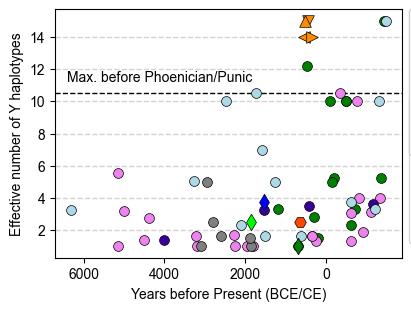

In [23]:
plot_y_div_panel(show=True, df_y_ps=df_y_ps)

# [Optional] Save the Y Haplogroup Diversity
Plot over in './browse_divpca.ipynb'

In [13]:
df_y_it.to_csv("./output/tables/ydiv/it.tsv", sep="\t", index=False)
df_y_fr.to_csv("./output/tables/ydiv/fr.tsv", sep="\t", index=False)
df_y_ib.to_csv("./output/tables/ydiv/ib.tsv", sep="\t", index=False)
df_y_lev.to_csv("./output/tables/ydiv/lev.tsv", sep="\t", index=False)
df_y_aegean.to_csv("./output/tables/ydiv/aeg.tsv", sep="\t", index=False)
df_punic.to_csv("./output/tables/ydiv/pun.tsv", sep="\t", index=False)


# 1b) Visualize Punic Y Haplogroup Diversity 
Preperation work: Load all Punic Y Haplogroups

In [ ]:
df_punic["location"].value_counts()

## Manually overwrite some automatic haplogroup calls
The new calls were manually called, pulling down against ISOGG19/20

In [7]:
set_age_ydiv_df(df_punic, site="I22114", age="I1", site_col="iid", age_col="Y_haplo")
set_age_ydiv_df(df_punic, site="I21197", age="L", site_col="iid", age_col="Y_haplo")
set_age_ydiv_df(df_punic, site="I18189", age="E1a1", site_col="iid", age_col="Y_haplo")
set_age_ydiv_df(df_punic, site="I11805", age="G2a1a1", site_col="iid", age_col="Y_haplo")
set_age_ydiv_df(df_punic, site="I21856", age="J1a2b~", site_col="iid", age_col="Y_haplo")

### Define colors and symbols

In [ ]:
df_punic["Y_h"]= df_punic["Y_haplo"].str[:4]
counts = df_punic["Y_h"].value_counts().reset_index()
counts = counts.sort_values("index")

### Merge in Colors
df_c = pd.DataFrame([["C1a2","#577590"], ["E1a1","#ffee32"], ["E1b1","#ffd100"], 
                     ["G2a1","#9b5de5"], ["G2a2","#f15bb5"], ["I1","#a4ac86"], ["I2a1","#656d4a"], 
                     ["J1a2","#0e6ba8"], ["J2a1", "blue"], ["J2a2","aqua"], ["J2b2","#a6e1fa"],["L","#ff9505"], 
                     ["R1a1","gray"], ["R1b1","#595959"], ["T1a1","#29bf12"], ["T1a2","#abff4f"]])
df_c.columns = ["index", "c"]

counts = pd.merge(counts, df_c, on="index", how="left")
counts["cs"] = np.concatenate(([0], np.cumsum(counts["Y_h"])[:-1]))
counts["means"] = counts["cs"] + counts["Y_h"]/2
counts["labels"] = counts["index"].str[:] + " (" + counts["Y_h"].astype("str").str[:] + ")"

df_pt = pd.merge(df_punic, counts[["index", "c", "means"]], how="left", left_on="Y_h", right_on="index") # prepare the indivdiual summary

### Merge in Markers
df_ms = pd.DataFrame([["Punic_Early", "o"],["Punic_Late", "o"],["Punic_Late2", "o"]])
df_ms.columns = ["label", "m"]
df_pt = pd.merge(df_pt, df_ms, how="left", on="label") # prepare the indivdiual summary

### Overall Pie chart

Saved to: ./figures/div/y_total.pdf


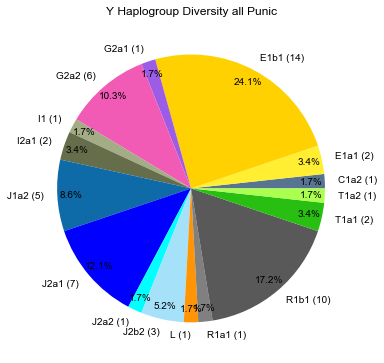

In [23]:
savepath  = "./figures/div/y_total.pdf" 

plt.figure(figsize=(6,8))
ax = plt.gca()
ax.pie(counts["Y_h"], 
       labels=counts["labels"], 
       autopct='%1.1f%%', colors=counts["c"], pctdistance=0.9)
ax.set_title("Y Haplogroup Diversity all Punic")

if len(savepath) > 0:
    plt.savefig(savepath, bbox_inches = 'tight', 
                pad_inches = 0, dpi=600)
    print(f"Saved to: {savepath}")
    
plt.show()

## Make Plot per Site

In [6]:
def plot_label_bar(ax, counts, xlim=[-0.51,0.51], lfs=10):
    """Plot the Label Bar"""
    for _, row in counts.iterrows():
        ax.bar(0, row["Y_h"], 1,  bottom=row["cs"], color=row["c"], edgecolor="k")

    ax.set_xlim(xlim)
    ylim=[0,np.sum(counts["Y_h"])] # The Y Limit
    ax.set_ylim(ylim)
    ax.axes.get_xaxis().set_visible(False) # Turn off x axis
    #ax.axes.grid(b=None)

    ax_r = ax.twinx()
    ax_r.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    ax_r.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1.0], rotation=0, fontsize=lfs)

    ax.set_yticks(counts["means"] )
    ax.set_yticklabels(counts["labels"] , rotation=0, fontsize=10)
    for ytick, c in zip(ax.get_yticklabels(), counts["c"]):
        ytick.set_color(c)

    ttl = ax.set_title("Y Haplogroup \nFrequency", fontsize=fst)
    ttl.set_position([.0, 1.01])

def plot_site_y(df, ax, ec ="k", title="", rot=50, 
                delta_x=0.3, hlines=[], ha="left"):
    """Plot Y chromosome div. per site.
    df: Y Haplo Dataframe
    ax: Axis to plot on"""
    ### Calc x shifts bc of counts
    df["s_x"] = 0 # Specify def value
    vs = set(df["Y_h"])
    for v in vs:
        idx = df["Y_h"] == v
        df.loc[idx, "s_x"] = (np.arange(np.sum(idx)) - (np.sum(idx)-1)/2)   * delta_x
        #if np.sum(idx)>1:
            #df.loc[idx, "s_x"] = np.arange(np.sum(idx)) / (np.sum(idx)-1) #- (np.sum(idx)-1)/2
    
    ax.set_title(title, rotation=rot, ha=ha)
    ax.set_xticks([])
    ax.set_yticks([])
    
    for h in hlines:
        ax.axhline(h, c="gray", ls="--", lw=0.5)
    
    for m in set(df["m"]):  # Iterate over all markers
        dft = df[df["m"]==m]
        ax.scatter(dft["s_x"], dft["means"],  #+np.random.random(len(df))-0.5 
                   ec=ec, c = dft["c"], marker=m)
    
    ax.set_ylim(ylim)
    ax.set_xlim([-1,1])  # Plot range is 0,1

In [ ]:
savepath = "./figures/div/y_persite.pdf"
figsize = (8,8)
lfs = 10 # Label Fontsize
fst = 12 # Fontsize Axis label
ec = "k"
delta_x=0.3

sites = ["Kerkouene", "Carthage", "Tharros", "MonteSirai",  
         "Villamar", "Eivissa", "Malaga", "Villaricos", "Selinunte", 
         "Lilybaeum", "Birgi", "Motya", "Akhziv"]
w= df_pt["location"].value_counts()[sites].values


####################
### Do the actual figure

fig = plt.figure(figsize=figsize) 
gs = gridspec.GridSpec(1, 2, width_ratios=[0.3, 8], wspace=0.12)

# Do the left bar
ax = plt.subplot(gs[0]) 
plot_label_bar(ax, counts, lfs=lfs) 

# Plot IIDs per Site
gs1 = gridspec.GridSpecFromSubplotSpec(1, len(sites), width_ratios=np.sqrt(w), 
                                       subplot_spec = gs[1], wspace=0.01) # width_ratios=[1,1,10]
ylim=[0,np.sum(counts["Y_h"])]

for i, s in enumerate(sites):
    dft = df_pt[df_pt["location"]==s].sort_values(by="age", ascending=False).copy()
    ax = plt.subplot(gs1[i])
    plot_site_y(dft, ax=ax, ec=ec, title= f"{s} ({w[i]})", 
                delta_x=delta_x, hlines=counts["cs"])
    
if len(savepath) > 0:
    plt.savefig(savepath, bbox_inches = 'tight', 
                pad_inches = 0, dpi=600)
    print(f"Saved to: {savepath}")

plt.show()

In [ ]:
df_punic["label"]

In [ ]:
df_punic[df_punic["Y_h"]=="E1b1"]["Y_haplo"].str[:8]

#E1b1b1b2a
# E1b1b1a1 very Greek (need to check whether 
# E1b1b1b2 more Eastern Med.

In [ ]:
df_punic[df_punic["Y_haplo"].str[:8]=="E1b1b1b2"]

# 2) Plot PCA Diversity

### Helper Functions

In [7]:
def get_pca_div_region(df, region="", min_n=10, metric="mean_dist", col_loc="loc"):
    """Get a Dataframe of Y haplogroup diversities per sites"""
    df_reg = df[df["region"].isin(region)]
    cts = df_reg[col_loc].value_counts()
    sites = cts[cts>=min_n].index.values
    
    df_res = create_pca_div_df(df, sites=sites, metric=metric, col_loc=col_loc)
    return df_res

def create_pca_div_df(df, sites=[], min_n=10, col_loc="loc", age_delta=300,
                      metric="mean_dist"):
    """Take Meta Data as input, and for each site calculate diversity metric.
    metric: Whhich metric (var: Variance, mean_dist: mean pw. distance
    age_delta: max temp dist from median age"""
    data = []
    
    for s in sites:
        dft = df[df[col_loc]==s] # Extract Site df 
        if len(dft)==0:
            raise RuntimeWarning(f"Site {s} has no matching samples")
        
        dft, age = filter_df_age(dft, age_delta=age_delta) # Filter to samples within age range
        m = len(dft) # Filtered df
        if m >= min_n: # Calculate Variance    
            
            if metric=="var":
                vars2 = np.var(dft[["pc1", "pc2"]], axis=0)
                var = np.sum(vars2)
                      
            elif metric=="mean_dist":
                ds = pdist(dft[["pc1", "pc2"]].values)
                var = np.mean(ds)
       
            else:
                raise RuntimeWarning(f"Metric {metric} not found!")
                
            data.append([s, age, m, var]) 
        else: 
            continue
    
    # Make the summary Data Frame
    df_res = pd.DataFrame(data)
    df_res.columns = ["loc", "age", "n", "div"]
    return df_res

In [14]:
min_snp = 20000
path_pca = "./output/pca/v54.1var/20230425.varPCA.v54.1.construct_WE_NA_PCA.smYES.outitY.evec.txt"
path_meta = "/n/groups/reich/hringbauer/Data/v54.1.anno.csv" 

df = pd.read_csv(path_pca, 
                 sep=r"\s+", skiprows=1, header=None)
df.columns=["iid", "pc1", "pc2", "pc3", "pc4", "pop"]
df_meta = pd.read_csv(path_meta, sep=",")
df2 = df_meta[["iid", "Master ID", "loc", "n_cov_snp", 
               "mean_cov", "sex", "age", "contact", "clst", "region", "study"]]
df = pd.merge(df, df2, on="iid", how="left")
df["clst"].fillna(inplace = True, value="missing") # Fill NaNs

idx = (df["n_cov_snp"]<min_snp)
df = df[~idx]
df.loc[df["loc"].isnull(), "loc"]="not assigned"
print(f"Filtered to {len(df)} Individuals based on Min SNP: {min_snp}")

df = df.sort_values(by="n_cov_snp", ascending=False)
dup = (df["Master ID"].duplicated() & ~df["Master ID"].isnull())
df = df[~dup].copy().reset_index(drop=True)
print(f"Filtered to {len(df)} based on duplicates")

# Remove female Sudan Outlier
idx = df["iid"]=="I22257" 
df=df[~idx].copy().reset_index(drop=True)
print(f"Filtered to {len(df)} based on manual removals")
#df[df["pop"].str.contains("Lebanon")]

### Seperate Individuals from Punic project
df1 = pd.read_csv("./data/cluster_assignments_punic.v54.1j.tsv", sep="\t")
print(f"Extracted IIDs of {len(df1)} IIDs in Punic Project")
df_p_pca = pd.merge(df, df1, on="iid")
print(f"Merged to {len(df_p_pca)} Punic IIDs")

### Remove Romans from Punic dataset
df_p_pca = df_p_pca[~df_p_pca["labelPCA"].str.contains("Roman")]
print(f"Filtered to {len(df_p_pca)} Phoenician-Punic Samples")

### Remove Punics from general Meta
df = df[~df["iid"].isin(df1["iid"])]
df_anc_pca = df[df["pop"]=="keep_anc"]
print(f"Filtered general Meta to {len(df_anc_pca)} ancient, non Punic individuals")

### Go to published indivduals only (Sanity Check - should be already done in PCA creation)
df_anc_pca =df_anc_pca[~df_anc_pca["study"].str.contains("Unpublished")]
print(f"Filtered to {len(df_anc_pca)} published ancient IIDs")

Filtered to 3568 Individuals based on Min SNP: 20000
Filtered to 3568 based on duplicates
Filtered to 3568 based on manual removals
Extracted IIDs of 160 IIDs in Punic Project
Merged to 149 Punic IIDs
Filtered to 136 Phoenician-Punic Samples
Filtered general Meta to 2287 ancient, non Punic individuals
Filtered to 2279 published ancient IIDs


In [23]:
min_n = 10 # In Prep the Cutoff is at 10

### Context Sites
df_pca_it = get_pca_div_region(df_anc_pca, ["Italy"], min_n=min_n)
df_pca_fr = get_pca_div_region(df_anc_pca, ["France", "Germany", "Austria"], min_n=min_n)
df_pca_ib = get_pca_div_region(df_anc_pca, ["Spain", "Portugal"], min_n=min_n)
df_pca_lev = get_pca_div_region(df_anc_pca, ["Israel", "Lebanon"], min_n=min_n)
df_pca_aegean = get_pca_div_region(df_anc_pca, ["Greece", "Turkey"], min_n=min_n)
### Akhziv
df_pca_ph = create_pca_div_df(df_p_pca,  col_loc='location', min_n=7, sites=["Akhziv"])
### Punic Sites
sites=["Kerkouene", "Carthage", 'Villaricos', "Tharros",  "Selinunte", "Birgi", "Motya", "Lilybaeum"]
df_ps = pd.concat([create_pca_div_df(df_p_pca, [s], age_delta=500,  min_n=7, col_loc="location") 
                   for s in sites]) 
df_ps["m"] =  ["<",">","^","v", "o","X","h", "*"] # Set Markers for Plot
df_ps = df_ps.reset_index(drop=True)
set_age_ydiv_df(df_ps, site='Carthage', age=2300)
set_age_ydiv_df(df_ps, site='Tharros', age=2400)

### Context Data (Outgroups in our Study)
df_context = pd.read_csv("./output/tables/reference_samples_plot.v54.1.tsv", sep="\t")
print(f"Loaded {len(df_context)} Context Individuals")
labels_context = df_context["label"].value_counts().index
df_pca_context = create_pca_div_df(df_context, labels_context, age_delta=500,  
                  min_n=min_n, col_loc="label") 
### Mege color on Context PCA Div. Values
df_c = df_context.drop_duplicates("label")
df_pca_context = pd.merge(df_pca_context, df_c[["label", "color"]], 
                          left_on="loc", right_on="label", how="left")

Loaded 136 Context Individuals


In [22]:
def plot_pca_div_panel(ax=0, figsize=(6,4), df_ps=[], col_plot="div", ylim=[0, 0.04],
                       s=50, m="o", sf=1.4, lw = 0.5, c_punic="darkorange", show=False,
                       savepath=""):
    """Plot PCA Diversity Panel. Assumes that the data dataframes are defined externally.
    If axis not given, make new plot with figsize."""
    if ax==0:
        plt.figure(figsize=figsize)
        ax = plt.gca()
    
    ### Plot the ancient context data
    a1 = ax.scatter(df_pca_it["age"]-1950, df_pca_it[col_plot], c="green", ec="k", s=s, marker=m, lw=lw)
    a2 = ax.scatter(df_pca_fr["age"]-1950, df_pca_fr[col_plot], c="violet", ec="k", s=s, marker=m, lw=lw)
    a3 = ax.scatter(df_pca_ib["age"]-1950, df_pca_ib[col_plot], c="gray", ec="k", s=s, marker=m, lw=lw)
    a4 = ax.scatter(df_pca_lev["age"]-1950, df_pca_lev[col_plot], c="#390099", ec="k", s=s, marker=m, lw=lw)
    a5 = ax.scatter(df_pca_aegean["age"]-1950, df_pca_aegean[col_plot], c="lightblue", ec="k", s=s, marker=m, lw=lw)
    
    p9 = ax.scatter(df_pca_ph["age"]-1950, df_pca_ph[col_plot], c="orangered", ec="k", s=s, marker='H', lw=lw)

    plots_c, labels_c = [], []
    ### Plot the Context Data from our outgroups
    for _, row in df_pca_context.iterrows():
        p = ax.scatter(row["age"]-1950, row[col_plot], ec="k", c=row["color"], 
                   s=s*sf, marker="d", lw=lw)
        plots_c.append(p)
        labels_c.append(row["loc"])
    
    ### Plot the Punic data
    plots = []
    labels_p = []
    for _, row in df_ps.iterrows():
        p = ax.scatter(row["age"]-1950, row[col_plot], ec="k", c=c_punic, 
                       s=s*sf, marker=row["m"], lw=lw)
        plots.append(p)
        labels_p.append(row["loc"])
    
    ### Plot the prev. maximum line
    div_max = np.max(df_pca_aegean[df_pca_aegean["age"]>2500][col_plot])
    ax.axhline(div_max, c="k", ls="--", zorder=0, lw=1)
    ax.text(6500, div_max*1.05, "Max. before Phoenician/Punic", va="bottom")
    
    ############################################################
    ### Formating the plot
    ax.set_axisbelow(True)
    ax.grid(axis='y', color='lightgray', linestyle='dashed', linewidth=1, zorder=0)
    ax.set_ylabel("2D PCA Diversity")
    ax.set_xlabel("Years before Present (BCE/CE)")
    ax.invert_xaxis()
    
    #### Legend Punic
    plots.append(p9)
    labels_p.append("Akhziv")

    leg1 = ax.legend(plots, labels_p, fontsize=10, 
                     title = "Phoenician-Punic\nSites",
                     bbox_to_anchor=(1.00, 0.5), loc="lower left") #1.00, 1.03
    leg1.get_title().set_fontsize('10')
    leg1.get_title().set_fontweight("bold")
    ax.add_artist(leg1)

    ### Legends PCA Context
    leg2 = ax.legend(plots_c, labels_c, fontsize=10, 
                 title = "Mediterranean\nBA/IA Groups",
                 bbox_to_anchor=(1.00, 0.5), loc="upper left") #1.00, 1.03
    leg2.get_title().set_fontsize('10')
    leg2.get_title().set_fontweight("bold")
    ax.add_artist(leg2)
    

    ### Legend Context Sites (in other plot)
    if len(ylim)>0:
        ax.set_ylim(ylim)

    if len(savepath) > 0:
        plt.savefig(savepath, bbox_inches='tight', dpi=400)
        print(f"Saved to: {savepath}")
        
    if show:
        plt.show()

def master_div_plot(df_y_ps, df_ps, figsize=(6,7), savepath = "./figures/div/master_div.v3.png"):
    """Master Diversity Plot combining Y Div and PCA Div Plots"""

    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(2, 1, height_ratios=[1,1], hspace=0.02, figure=fig)
    
    # Do the left bar
    ax0 = plt.subplot(gs[0]) 
    ax1 = plt.subplot(gs[1]) 
    
    plot_y_div_panel(ax=ax0, df_y_ps=df_y_ps, show=False, leg_p=False)                 
    plot_pca_div_panel(ax=ax1, df_ps=df_ps, show=False)
    
    ### Some Formatting for the panel
    ax0.set_xlabel("")
    ax0.text(-0.14, 1.05, 'a', ha='left', va='top', 
            transform = ax0.transAxes, weight='bold')
    ax1.text(-0.14, 1.05, 'b', ha='left', va='top', 
            transform = ax1.transAxes, weight='bold')

    #plt.tight_layout(rect=[0, 0, 0.75, 1])
    #fig.set_tight_layout(False)
    
    ### Save the Figure
    if len(savepath) > 0:
        plt.savefig(savepath, dpi=400)
        print(f"Saved to: {savepath}")

    plt.show()

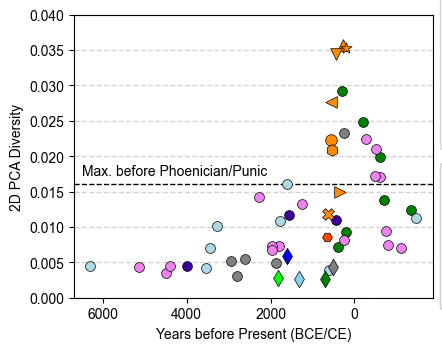

In [19]:
plot_pca_div_panel(df_ps=df_ps, show=True)

In [ ]:
df_pca_it#[df_pca_fr["div"]>2500]

# 3) Master Diversity Plot
Panel a and b

In [20]:
plt.rcParams['figure.constrained_layout.use'] = True

Saved to: ./figures/div/master_div.v6.pdf


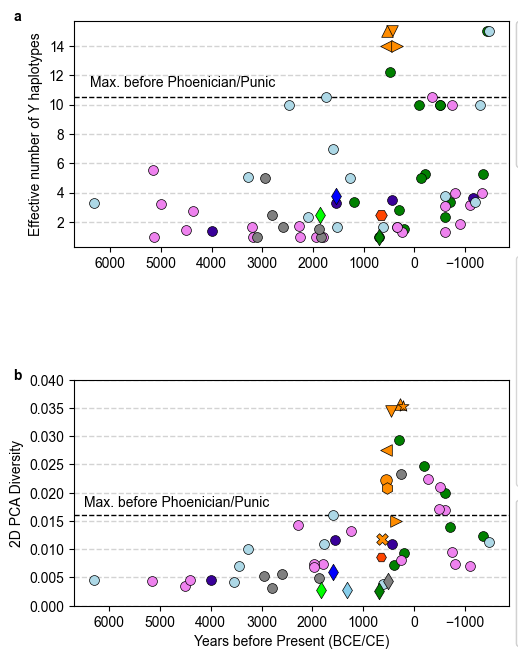

In [21]:
master_div_plot(df_y_ps=df_y_ps, df_ps=df_ps, 
                figsize=(7, 6.5),  savepath = "./figures/div/master_div.v6.pdf")

# 3b) Save the tabular values

### a) Save the Y Haplogroup Diversity

In [38]:
dfpa

,loc,age,males,D
0,Akhziv,2600.0,6,2.5


In [8]:
df_y_it["label"] = "Italy"
df_y_fr["label"] = "Central Europe"
df_y_ib["label"] = "Iberia"
df_y_lev["label"] = "Levant"
df_y_aegean["label"] = "Aegean"

df_y_context1 = df_y_context[["loc", "age", "males", "D"]].copy()
df_y_context1["label"] = "BA/IA Context"
df_y_ps["label"] = "Punic"
dfpa["label"] = "Phoenician"

In [9]:
dfm = pd.concat((df_y_it,df_y_fr,df_y_ib,df_y_lev,df_y_aegean, df_y_context1, df_y_ps, dfpa))

In [10]:
savepath="./output/tables/divs/y_div.v2.tsv"
dfm = dfm.sort_values(by="age", ascending=False)
dfm.to_csv(savepath, sep="\t", index=False)
print(f"Saved Y Div of {len(dfm)} Sites to: {savepath}")

Saved Y Div of 67 Sites to: ./output/tables/divs/y_div.v2.tsv


### b) Save the Autosomal Divs

In [61]:
df_pca_it["label"] = "Italy"
df_pca_fr["label"] = "Central Europe"
df_pca_ib["label"] = "Iberia"
df_pca_lev["label"] = "Levant"
df_pca_aegean["label"] = "Aegean"
df_pca_ph["label"] = "Phoenician"

df_pca_context1 = df_pca_context[["loc", "age", "n", "div"]].copy()
df_pca_context1["label"] = "BA/IA Context"

df_ps["label"]="Punic"

In [62]:
savepath = "./output/tables/divs/pca_div.v2.tsv"
dfm = pd.concat((df_pca_it,df_pca_fr,df_pca_ib,df_pca_lev, df_pca_aegean, df_pca_ph, df_pca_context1, df_ps))
dfm = dfm.sort_values(by="age", ascending=False)
dfm.to_csv(savepath, sep="\t", index=False)
print(f"Saved PCA Div of {len(dfm)} Sites to: {savepath}")

Saved PCA Div of 53 Sites to: ./output/tables/divs/pca_div.v2.tsv


In [63]:
dfm

,loc,age,n,div,label,m
1,"Barcın (Northwest Anatolia, Marmara)",8247.5,14,0.004468,Aegean,NaN
3,"Baden-Württemberg, Stuttgart-Mühlhausen I",7096.0,16,0.004314,Central Europe,NaN
11,"France, Yonne, Gurgy ""les Noisats"" Family A (1...",6450.0,11,0.003503,Central Europe,NaN
13,"Calvados, Fleury-sur-Orne",6350.5,10,0.004513,Central Europe,NaN
1,"Upper Galilee, Peki'in",5950.0,17,0.004467,Levant,NaN
5,"Çorum Province, Çamlıbel Tarlası",5499.0,12,0.004234,Aegean,NaN
7,"Samsun Province, İkiztepe",5394.0,10,0.007049,Aegean,NaN
2,"Malatya Province, Arslantepe",5219.5,14,0.010109,Aegean,NaN
4,"Barcelona, Cova de la Guineu",4900.0,10,0.005214,Iberia,NaN
3,"Alicante, Villena, Cueva de las Lechuzas",4750.0,10,0.003059,Iberia,NaN


# 5) Filtered Diversity Plots removing North African Ancestry

### 5a) PCA Diversity

In [11]:
frac_nafr_okay = 0.1

df_nafr = pd.read_csv("./data/punic-northAfrican-ancestry.tsv", sep="\t")
idx =  df_nafr["qpadm.norAf"] < frac_nafr_okay
df_nafr["include"]= idx

print(f"Loaded {len(df_nafr)} Individuals from Ilans qpAdm analsis with North African Fracton.")
print(f"{np.sum(idx)}/{len(idx)} with qpAdm North Afr. anestry < {frac_nafr_okay}")

Loaded 123 Individuals from Ilans qpAdm analsis with North African Fracton.
76/123 with qpAdm North Afr. anestry < 0.1


### Plot Histogram of North African Ancestry

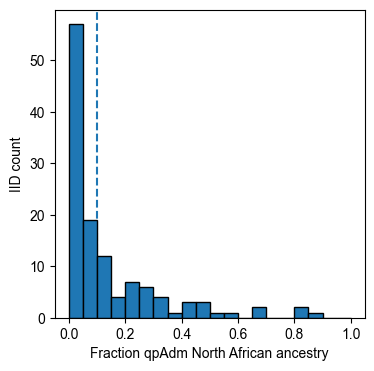

In [12]:
plt.figure(figsize=(4,4))
ax = plt.gca()
plt.hist(df_nafr["qpadm.norAf"], ec="k", bins=np.linspace(0,1,21))
ax.set_xlabel("Fraction qpAdm North African ancestry")
ax.set_ylabel("IID count")
ax.axvline(frac_nafr_okay, ls="--", zorder=0)
plt.savefig("./figures/nafr/nafr_qpadm_histo.pdf", bbox_inches = 'tight', 
                pad_inches = 0, dpi=400)
plt.show()

# Create downsamped Punic PCA Dataframes
Those are used in PCA plot

In [15]:
df_p_pca_eur = pd.merge(df_p_pca, df_nafr[["iid", "include"]])
df_p_pca_eur = df_p_pca_eur[df_p_pca_eur["include"]==True]

### Group Lilybaeum Sites by renaming
df_p_pca_eur = df_p_pca_eur.replace(["Birgi", "Motya"], "Lilybaeum")

In [20]:
sites=["Kerkouene", "Carthage", 'Villaricos', "Tharros",  "Selinunte", "Lilybaeum"]
df_ps1 = pd.concat([create_pca_div_df(df_p_pca_eur, [s], age_delta=500,  min_n=3, col_loc="location") 
                   for s in sites]) 
df_ps1["m"] =  ["<",">","^","v", "o", "*"] # Set Markers for Plot
set_age_ydiv_df(df_ps1, site='Carthage', age=2300)
set_age_ydiv_df(df_ps1, site='Tharros', age=2400)

Saved to: ./figures/div/pca_div_nafr.filter.png


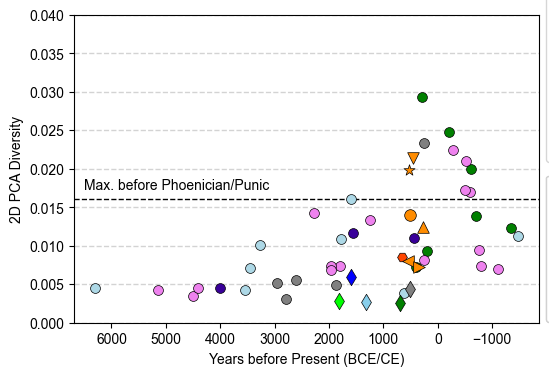

In [24]:
plot_pca_div_panel(df_ps= df_ps1, show=True, savepath="./figures/div/pca_div_nafr.filter.png")

### 5b) Filtered Y Diversity

In [25]:
idx1 = df_punic["Y_haplo"].str[:3] == "E1a"
idx2 = df_punic["Y_haplo"].str[0]=="L"
df_punic1 = df_punic[~idx1 & ~idx2]

In [29]:
df_punic[idx2]

,iid,Master ID,loc,lat,lon,age,region,study,clst,mean_cov,...,include,label_fine,location,label,clst_qpadm,cluster_geo,published,date range,direct date,SNPs
42,I21197,I21197,"Sicily, Selinunte, Manuzza",37.585,12.825,2225.0,Italy,Unpublished (Harald Ilan Punic),Italy_Sicily_Punic_Late,0.528608,...,1,Selinunte_Late,Selinunte,Punic_Late,PunicLateAegean,Sicily,NaN,"380-176 calBCE (2210Â±35 BP, 75.95Â±0.33 pMC, ...",y,634329


In [42]:
df_punic1[df_punic1["loc"].str.contains("Tharros")][["iid", "n_cov_snp", "Y_haplo"]]

,iid,n_cov_snp,Y_haplo
4,I22118,802359,E1b1b1a1
5,I22117,791179,R1b1a1b1a1a2b1
7,I22114,747236,I
9,I22115,765439,G2a2b2a1a1c1
15,I22119,773206,J1a2a1a2d2b2b2~
30,I22122,711166,E1b1b1a1b2


In [30]:
sites = ["Kerkouane", "Sardinia, Tharros",  "Sicily, Selinunte, Manuzza", "Tunis, Carthage"]
df_y_ps1 = pd.concat([create_ydiv_df(df_punic1, [s], min_m=5) for s in sites])
df_y_ps1["m"] = ["<", "v", "^", ">"]

set_age_ydiv_df(df_y_ps1, site='Tunis, Carthage', age=2300)
set_age_ydiv_df(df_y_ps1, site='Sardinia, Tharros', age=2400)

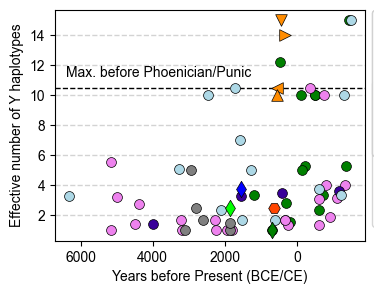

In [31]:
plot_y_div_panel(show=True, df_y_ps=df_y_ps1)

### 5c) Combined Master Plot (filtered NAFR)

Saved to: ./figures/div/master_div.v5nnafr.v3.pdf


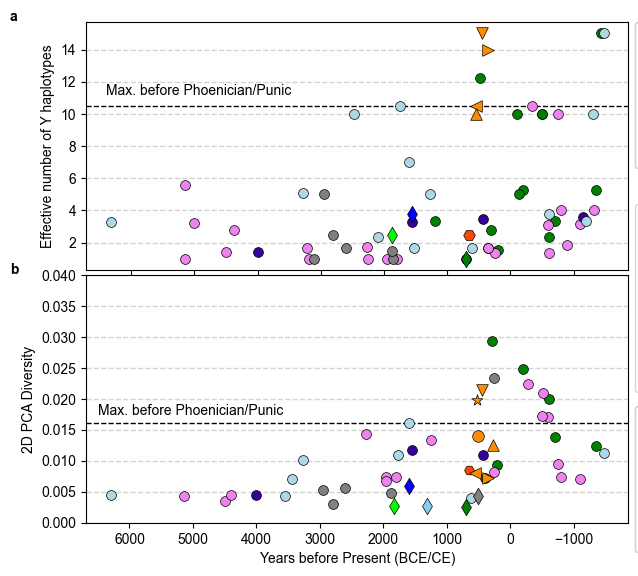

In [33]:
master_div_plot(df_y_ps1, df_ps=df_ps1, figsize=(7, 6.5),
                savepath = "./figures/div/master_div.v5nnafr.v3.pdf")

# Area 51
Test code here

In [9]:
print("test")

test


In [148]:
dft = df[df["loc"].str.contains("Iberia")]

In [149]:
dft["loc"].value_counts()

Series([], Name: count, dtype: int64)

In [159]:
df_y_greek = get_sub_df_region(df, ["Greece"], min_n=1)

In [160]:
df_y_greek

,loc,age,males,D
0,"Crete, Lasithi",4050.0,21,2.359551
1,"Crete, Chania",3225.0,10,5.000000
2,"Western Greece / Peloponnese, Achaea",3473.0,5,1.666667
3,"Central Greece, Euboea",4421.0,5,10.000000


In [161]:
df_y_greek = get_sub_df_region(df, ["Turkey"], min_n=1)

In [162]:
df_y_greek

,loc,age,males,D
0,"Malatya Province, Arslantepe",5227.0,12,5.076923
1,"Hatay Province, Tell Atchana/Alalakh",3689.5,7,10.500000
2,"Northwest Anatolia, Marmara, Barcın",8272.5,9,3.272727
3,"Hatay, Tell Atchana (Alalakh)",3550.0,8,7.000000
4,"Çapalıbağ, Yeşilbağcılar-YTEUAS (Aegean, Muğla...",475.0,6,15.000000
5,"Samantaş (Aegean, Muğla, Yatağan)",1346.0,6,3.750000
6,"Stratonikeia-West Church (Aegean, Muğla, Yatağan)",650.0,5,10.000000
7,"Tilbeşar Höyük (Southeast, Gaziantep)",750.0,5,3.333333
8,"Değirmendere (Aegean, Muğla, Yatağan)",2565.0,5,1.666667


In [168]:
dft = df[df["loc"]=="Hatay Province, Tell Atchana/Alalakh"]
dft["Y_haplo"].str[:3].value_counts()

Y_haplo
J1a    5
J2a    2
H      1
J2b    1
L      1
Name: count, dtype: int64

### Check Context Data

In [50]:
df_pca_context

,loc,age,n,div,label,color
0,Canaanite MLBA,3550.0,35,0.005960,Canaanite MLBA,blue
1,Sardinia BA,3775.0,11,0.002771,Sardinia BA,lime
2,Iberia IA,2464.5,16,0.004390,Iberia IA,gray
3,Sicily Polizzello IA,2650.0,19,0.002590,Sicily Polizzello IA,green
4,Mycenean BA,3264.0,12,0.002710,Mycenean BA,skyblue
5,Tunisia M/N,6338.5,5,0.005074,Tunisia M/N,yellow
6,Sicily Motya MBA,3485.0,5,0.015138,Sicily Motya MBA,olive
7,Guanche Pre-Contact,1014.0,5,0.004256,Guanche Pre-Contact,sienna
8,Menorca LBA,2925.0,5,0.002510,Menorca LBA,lightgray


In [43]:
df_c

,iid,pc1,pc2,pc3,pc4,pop,Master ID,clst,loc,n_cov_snp,mean_cov,sex,age,contact,lat,lon,study,color,label
0,I10770,-0.025286,0.000785,0.006130,0.001217,Israel_MLBA,I10770,Israel_MLBA,"Megiddo, Jezreel Valley",712791.0,0.593993,M,3450.0,"Cradic, Melissa",32.584722,35.016944,AgranatTamirCell2020,blue,Canaanite MLBA
35,I13518,-0.004107,-0.008241,0.009536,-0.007781,Greece_BA_Mycenaean,I13518,Greece_BA_Mycenaean,"Pylos, Palace of Nestor",932734.0,0.777278,M,3085.0,"Pinhasi, Ron; Davis, Jack; Stocker, Sharon; Sc...",37.026797,21.694586,LazaridisAlpaslanRoodenbergScience2022,skyblue,Mycenean BA
47,I19679,0.014434,-0.020880,0.002833,-0.005964,Spain_IA,I19679,Spain_IA,"Tella-Sin, Huesca, Coro Trasito",863200.0,0.719333,F,3300.0,"Lalueza-Fox, Carles",42.593600,0.187400,Unpublished,gray,Iberia IA
67,ORC003,0.009145,-0.030970,0.018266,-0.010098,Italy_Sardinia_BA_Nuragic,ORC003,Italy_Sardinia_BA_Nuragic,"Sardinia, Perdasdefogu, NUO, S’Orcu ‘e Tueri",830219.0,0.691849,M,3181.0,John Novembre,39.667222,9.426111,MarcusNatureCommunications2020,lime,Sardinia BA
90,I13383,0.001325,-0.016752,0.015679,-0.007241,Italy_Sicily_IA_Polizzello,I13383,Italy_Sicily_IA_Polizzello,"Sicily, Polizzello",886517.0,0.738764,M,2733.0,"Caramelli, David",37.608431,13.834838,Unpublished (Alissa Himera),green,Sicily Polizzello IA
109,I22238,-0.000451,-0.020464,0.019014,-0.011087,include,I22238,Italy_Sicily_MBA,"Sicily, Motya",748924.0,0.624103,M,3705.0,"Caramelli, David",37.535300,12.263700,Unpublished (Harald Punic),olive,Sicily Motya MBA
114,I22580,-0.050991,-0.054699,-0.062462,-0.063224,include,I22580,Tunisia_N,Doukanet el Khoutifa,945563.0,0.787969,F,7039.0,"Pinhasi, Ron; Pinhasi, Ron; Pinhasi, Ron",35.851570,9.549478,Unpublished (Harald Punic),yellow,Tunisia M/N
122,gun011_noUDG.SG,-0.034383,-0.041123,-0.037387,-0.045185,CanaryIslands_Guanche.SG,gun011,CanaryIslands_Guanche.SG,Tenerife,1053821.0,0.878184,M,1137.0,..,28.268611,-16.605556,RodriguezVarelaCurrentBiology2017,sienna,Guanche Pre-Contact
127,I3315_enhanced,0.014377,-0.017888,0.003593,-0.002600,Spain_Menorca_LBA_new,I3315,Spain_Menorca_LBA_new,"Balearic Islands, Menorca, Naveta des Tudons",794929.0,0.662441,M,2809.0,"Pinhasi, Ron",39.999000,3.891000,PattersonNature2021 (higher coverage of previo...,lightgray,Menorca LBA
132,I3339_noUDG,-0.034278,-0.020367,-0.013100,-0.017657,Egypt_Hellenistic_Roman_noUDG,I3339,Egypt_Hellenistic_Roman_noUDG,Thebes,387029.0,0.322524,M,1978.0,"Monge, Janet",25.720556,32.610278,Unpublished,tan,Egypt Hellenistic
